<a href="https://colab.research.google.com/github/RupeshSharma14/ML-Algorithms/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
# Loading the data

import scipy.io as sio

data = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/ex3data1.mat")
X = data["X"]                         # shape = (5000, 400)
y = data["y"]
y = y.reshape(len(y))                 # shape = (5000,)

m, n = X.shape
input_layer_size = 400
hidden_layer_size = 25
K = 10

In [3]:
# Remapping of y

def remap(y, K):
  m = len(y)
  out = np.zeros((m, K))
  for index in range(m):
    out[index][y[index] - 1] = 1
  return out

y = remap(y, K)

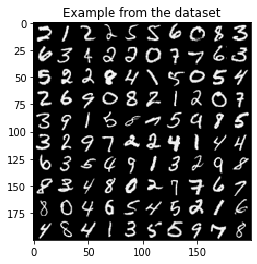

In [4]:
# Visualisation of 100 random samples from the data

import random
from PIL import Image

# get 100 random images from the dataset
num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# loop over the images, turn them into a PIL image
i = 0
for col in range(10):
  for row in range(10):
    array = samples[i]
    array = ((array / max(array)) * 255).reshape((20, 20)).T # redistribute values
    img = Image.fromarray(array)
    display_img.paste(img, (col * 20, row * 20))
    i += 1
    
plt.title("Example from the dataset")
plt.imshow(display_img, interpolation = "nearest");

In [5]:
# Random initialization of weights

def initialize_random_weights(L_out, L_in):
  init_epsilon = np.sqrt(6) / np.sqrt(L_out + L_in)
  weight = np.random.rand(L_out, L_in + 1) * (2 * init_epsilon) - init_epsilon
  return weight

In [6]:
theta1 = initialize_random_weights(hidden_layer_size, input_layer_size)   # shape = (25, 401)
theta2 = initialize_random_weights(K, hidden_layer_size)                  # shape = (10 ,26)
init_nn_params = np.concatenate([theta1.flatten(), theta2.flatten()])     # shape = (10285, )

In [7]:
# Sigmoid function

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [8]:
# Add bias

def add_bias(X):
  m = len(X)
  x0 = np.ones((m, 1))
  X = np.c_[x0, X]
  return X

In [9]:
# Forward propagation vectorization (For cost function)

def forward_propagation(X, theta1, theta2):
  activation_layer1 = sigmoid(add_bias(X) @ theta1.T)    # shape = (5000, 25)
  hx = sigmoid(add_bias(activation_layer1) @ theta2.T)   # shape = (5000, 10)
  return hx

In [10]:
# Cost function

def cost_func(nn_params, X, y, input_layer_size, hidden_layer_size, K, lambda_ = 0):
  m = len(y)
  
  theta1 = nn_params[: hidden_layer_size * (input_layer_size +1)].reshape(hidden_layer_size, (input_layer_size + 1))
  theta2 = nn_params[hidden_layer_size * (input_layer_size +1) : ].reshape(K, (hidden_layer_size + 1))

  hx = forward_propagation(X, theta1, theta2)
  
  cost = (1 / m) * np.sum((-y * np.log(hx) - (1 - y) * np.log(1 - hx)))
  regularization =  (lambda_ / (2 * m)) * (np.sum(theta1 ** 2) + np.sum(theta2 ** 2))

  return cost + regularization

In [11]:
J = cost_func(init_nn_params, X, y, input_layer_size, hidden_layer_size, K)
J

8.933272565424275

In [12]:
# Back propagation

def back_propagation(nn_params, X, y, input_layer_size, hidden_layer_size, K, lambda_ = None):
  m = len(y)

  theta1 = nn_params[: hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
  theta2 = nn_params[hidden_layer_size * (input_layer_size + 1) :].reshape(K, (hidden_layer_size +1))

  Delta1 = np.zeros(theta1.shape)
  Delta2 = np.zeros(theta2.shape)

  for i in range(m):

    Xi = np.concatenate(([1], X[i]))
    activation_layer2 = sigmoid(theta1 @ Xi)
    activation_layer2 = np.concatenate(([1], activation_layer2))
    hx = sigmoid(theta2 @ activation_layer2)
    
    
    delta3 = hx - y[i]
    delta2 = theta2[:, 1:].T @ delta3 * activation_layer2[1:] * (1 - activation_layer2[1:])
    
    Delta2 += delta3.reshape(len(delta3), 1) @ activation_layer2.reshape(1, len(activation_layer2))
    Delta1 += delta2.reshape(len(delta2), 1) @ Xi.reshape(1, len(Xi))

  if lambda_:
    grad1 = (1 / m) * Delta1 + (lambda_ / m) * theta1
    grad2 = 1 / m * Delta2 + (lambda_ / m) * theta2
  else:
    grad1 = 1 / m * Delta1
    grad2 = 1 / m * Delta2

  gradient = np.concatenate((grad1.flatten(), grad2.flatten()))

  return gradient

In [13]:
back_propagation(init_nn_params, X, y, input_layer_size, hidden_layer_size, K, lambda_=1)

array([ 5.73223891e-02, -1.89029396e-05, -5.52252856e-06, ...,
        4.47194552e-02,  4.53302821e-02,  3.73241501e-02])

In [14]:
# Computing Gradient  (For Gradient Checking)

def numerical_gradient(nn_params, X, y, input_layer_size, hidden_layer_size, K, lambda_):
  numgrad = np.zeros(nn_params.shape)
  epsilon_vector = np.zeros(nn_params.shape)
  epsilon = 0.00001    # 1e - 4
  for i in range(len(nn_params)):
    epsilon_vector[i] = epsilon
    
    loss1 = cost_func(nn_params - epsilon_vector, X, y, input_layer_size, hidden_layer_size, K, lambda_)
    loss2 = cost_func(nn_params + epsilon_vector, X, y, input_layer_size, hidden_layer_size, K, lambda_)

    numgrad[i] = (loss2 - loss1) / (2 * epsilon)
    epsilon_vector[i] = 0

  return numgrad

In [15]:
# Gradient Checking

def debug_initialize_weights(L_out, L_in):
  W = np.sin(np.arange(1, (L_in + 1) * L_out + 1)) / 10
  return W.reshape(L_out, L_in + 1)

def check_gradient(lambda_ = 0):
  input_layer_size = 3
  hidden_layer_size = 5
  K = 3
  m = 5

  theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
  theta2 = debug_initialize_weights(K, hidden_layer_size)
  X = debug_initialize_weights(m, input_layer_size - 1)
  y = 1 + np.mod(np.arange(1, m+1), K)
  y = remap(y, K)

  # Unroll parameters
  nn_params = np.concatenate([theta1.flatten(), theta2.flatten()])

  # Backpropagation
  backprop_gradient = back_propagation(nn_params, X, y, input_layer_size, hidden_layer_size, K, lambda_)

  # Numerical Gradient
  num_gradient = numerical_gradient(nn_params, X, y, input_layer_size, hidden_layer_size, K, lambda_)

  # Compute the difference
  diff = np.linalg.norm(num_gradient - backprop_gradient) / np.linalg.norm(backprop_gradient + num_gradient)
  print('Relative difference : {}'.format(diff))   # Difference should be less than 1e-9

In [16]:
print('The gradients without regularization: ')
check_gradient()

print('\n-------------\n')

print('The gradients with regularization (lambda=3): ')
check_gradient(lambda_=3)

The gradients without regularization: 
Relative difference : 1.22372694010938e-10

-------------

The gradients with regularization (lambda=3): 
Relative difference : 1.190056656035894e-10


In [17]:
# Training the neural network

lambda_ = 3
args = (X, y, input_layer_size, hidden_layer_size, K, lambda_)

results = minimize(cost_func, init_nn_params, args = args, method = "CG", jac=back_propagation, options={"maxiter": 50, "disp": 0})
nn_params =results.x

theta1 = nn_params[: hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
theta2 = nn_params[hidden_layer_size * (input_layer_size + 1) :].reshape(K, (hidden_layer_size +1))

In [18]:
prediction = forward_propagation(X, theta1, theta2)

accuracy = np.mean(np.argmax(prediction, axis = 1) == np.argmax(y, axis = 1)) * 100
print(f"Training set accuracy using the neural network : {round(accuracy, 2)} %")

Training set accuracy using the neural network : 95.34 %
